In [1]:
import torch
from typing import Tuple


class LearnedGatingSigmoid(torch.nn.Module):
    def __init__(self, gate_shape: Tuple[int]):
        super(LearnedGatingSigmoid, self).__init__()
        self.gating = torch.nn.Parameter(
            torch.rand(gate_shape, device="cuda"),
#             torch.nn.init.xavier_uniform_(torch.empty(gate_shape, device="cuda")),
            requires_grad=True
        )
        

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return (self.gating * input).sigmoid()

In [2]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3).to("cuda")
gate = LearnedGatingSigmoid((64, 222, 222))
gate(conv1(torch.randn(1, 3, 224, 224, device="cuda"))).shape

torch.Size([1, 64, 222, 222])

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Based on https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/
# https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
# "Basic Net"


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1))


def mCNN_k_gating(c=64, num_classes=10):  # no Batch Norm
    return nn.Sequential(
        # Prep
        nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True),
#         nn.ReLU(inplace=True),
        LearnedGatingSigmoid((c, 32, 32)).to("cuda"),
        # Layer 1
        nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False),
#         nn.ReLU(inplace=True),
        LearnedGatingSigmoid((c * 2, 32, 32)).to("cuda"),
        nn.MaxPool2d(2),
        # Layer 2
        nn.Conv2d(c * 2, c * 4, kernel_size=3, stride=1, padding=1, bias=False),
#         nn.ReLU(inplace=True),
        LearnedGatingSigmoid((c * 4, 16, 16)).to("cuda"),
        nn.MaxPool2d(2),
        # Layer 3
        nn.Conv2d(c * 4, c * 8, kernel_size=3, stride=1, padding=1, bias=False),
#         nn.ReLU(inplace=True),
        LearnedGatingSigmoid((c * 8, 8, 8)).to("cuda"),
        nn.MaxPool2d(2),
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c * 8, num_classes, bias=False),
    )


In [4]:
from torchinfo import summary

In [5]:
model = mCNN_k_gating().to("cuda")

# for p in model[0].parameters():
#     p.requires_grad = False
# for p in model[2].parameters():
#     p.requires_grad = False
# for p in model[5].parameters():
#     p.requires_grad = False
# for p in model[8].parameters():
#     p.requires_grad = False


summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─LearnedGatingSigmoid: 1-2              [1, 64, 32, 32]           65,536
├─Conv2d: 1-3                            [1, 128, 32, 32]          73,728
├─LearnedGatingSigmoid: 1-4              [1, 128, 32, 32]          131,072
├─MaxPool2d: 1-5                         [1, 128, 16, 16]          --
├─Conv2d: 1-6                            [1, 256, 16, 16]          294,912
├─LearnedGatingSigmoid: 1-7              [1, 256, 16, 16]          65,536
├─MaxPool2d: 1-8                         [1, 256, 8, 8]            --
├─Conv2d: 1-9                            [1, 512, 8, 8]            1,179,648
├─LearnedGatingSigmoid: 1-10             [1, 512, 8, 8]            32,768
├─MaxPool2d: 1-11                        [1, 512, 4, 4]            --
├─MaxPool2d: 1-12                        [1, 512,

In [6]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LearnedGatingSigmoid()
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (3): LearnedGatingSigmoid()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (6): LearnedGatingSigmoid()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (9): LearnedGatingSigmoid()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Linear(in_features=512, out_features=10, bias=False)
)

In [7]:
import torch
from torchvision import datasets, transforms
from notebook_train import run_train_test_loop, test

# for now, no augmentations

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset1 = datasets.CIFAR10('data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.CIFAR10('data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(
    dataset1, 
    num_workers = 4, 
    pin_memory = True, 
    batch_size=128, 
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset2,  
    num_workers = 4, 
    pin_memory = True, 
    batch_size=128
)



Files already downloaded and verified


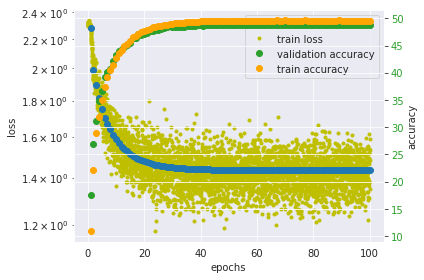

best acc: 48.82


In [8]:
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_sigmoid_gating_train_all", 
    epochs=100, 
    device=device
)    


In [9]:
model = mCNN_k_gating().to("cuda")

for p in model[0].parameters():
    p.requires_grad = False
for p in model[2].parameters():
    p.requires_grad = False
for p in model[5].parameters():
    p.requires_grad = False
for p in model[8].parameters():
    p.requires_grad = False


summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           (1,792)
├─LearnedGatingSigmoid: 1-2              [1, 64, 32, 32]           65,536
├─Conv2d: 1-3                            [1, 128, 32, 32]          (73,728)
├─LearnedGatingSigmoid: 1-4              [1, 128, 32, 32]          131,072
├─MaxPool2d: 1-5                         [1, 128, 16, 16]          --
├─Conv2d: 1-6                            [1, 256, 16, 16]          (294,912)
├─LearnedGatingSigmoid: 1-7              [1, 256, 16, 16]          65,536
├─MaxPool2d: 1-8                         [1, 256, 8, 8]            --
├─Conv2d: 1-9                            [1, 512, 8, 8]            (1,179,648)
├─LearnedGatingSigmoid: 1-10             [1, 512, 8, 8]            32,768
├─MaxPool2d: 1-11                        [1, 512, 4, 4]            --
├─MaxPool2d: 1-12                        

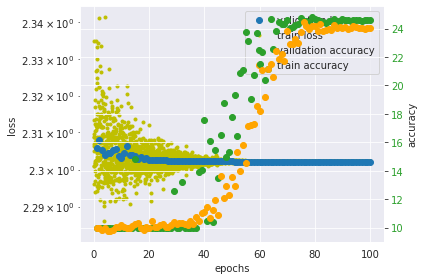

best acc: 24.81


In [10]:
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_sigmoid_gating", 
    epochs=100, 
    device=device
)    


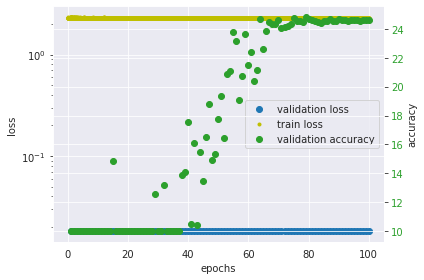

best acc: 24.81


In [180]:
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_sigmoid_gating", 
    epochs=100, 
    device=device
)    


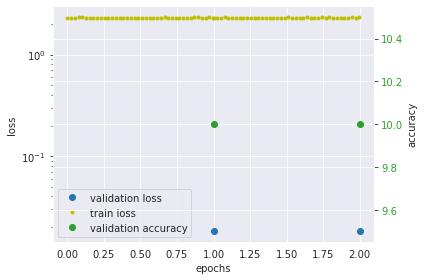

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [181]:
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_sigmoid_gating_300epochs", 
    epochs=300, 
    device=device
)    


In [11]:
import torch.nn as nn
import torch.nn.functional as F

# Based on https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/
# https://github.com/davidcpage/cifar10-fast/blob/master/experiments.ipynb
# "Basic Net"


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1))


def mCNN_k_sigmoid(c=64, num_classes=10):  # no Batch Norm
    return nn.Sequential(
        # Prep
        nn.Conv2d(3, c, kernel_size=3, stride=1, padding=1, bias=True),
        nn.Sigmoid(),
        # Layer 1
        nn.Conv2d(c, c * 2, kernel_size=3, stride=1, padding=1, bias=False),
        nn.Sigmoid(),
        nn.MaxPool2d(2),
        # Layer 2
        nn.Conv2d(c * 2, c * 4, kernel_size=3, stride=1, padding=1, bias=False),
        nn.Sigmoid(),
        nn.MaxPool2d(2),
        # Layer 3
        nn.Conv2d(c * 4, c * 8, kernel_size=3, stride=1, padding=1, bias=False),
        nn.Sigmoid(),
        nn.MaxPool2d(2),
        nn.MaxPool2d(4),
        Flatten(),
        nn.Linear(c * 8, num_classes, bias=False),
    )

model = mCNN_k_sigmoid().to("cuda")

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,792
├─Sigmoid: 1-2                           [1, 64, 32, 32]           --
├─Conv2d: 1-3                            [1, 128, 32, 32]          73,728
├─Sigmoid: 1-4                           [1, 128, 32, 32]          --
├─MaxPool2d: 1-5                         [1, 128, 16, 16]          --
├─Conv2d: 1-6                            [1, 256, 16, 16]          294,912
├─Sigmoid: 1-7                           [1, 256, 16, 16]          --
├─MaxPool2d: 1-8                         [1, 256, 8, 8]            --
├─Conv2d: 1-9                            [1, 512, 8, 8]            1,179,648
├─Sigmoid: 1-10                          [1, 512, 8, 8]            --
├─MaxPool2d: 1-11                        [1, 512, 4, 4]            --
├─MaxPool2d: 1-12                        [1, 512, 1, 1]           

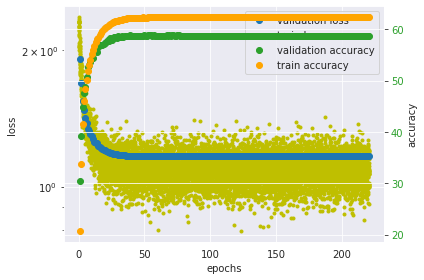

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [12]:
run_train_test_loop(
    model, 
    train_loader, 
    test_loader, 
    "cifar_10_sigmoid", 
    epochs=300, 
    device=device
)    
